In [13]:
from dolfin import *
import matplotlib.pyplot as plt

In [14]:
mesh = UnitSquareMesh(8, 8,  diagonal="left")

In [15]:
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], 0) or near(x[1], 0)) and 
                (not ((near(x[0], 0) and near(x[1], 1)) or 
                        (near(x[0], 1) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], 1) and near(x[1], 1):
            y[0] = x[0] - 1.
            y[1] = x[1] - 1.
        elif near(x[0], 1):
            y[0] = x[0] - 1.
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 1.
            
PBC=PeriodicBoundary()

P0_el = FiniteElement("DG", mesh.ufl_cell(), 0) 
P1_el = FiniteElement("CG", mesh.ufl_cell(), 1)
P_mixed = MixedElement([P0_el,P0_el,P0_el,P1_el,P1_el])

W = FunctionSpace(mesh, P_mixed, constrained_domain=PBC)

In [16]:
(s1,s2,s3,u1,u2) = TrialFunctions(W)
(t1,t2,t3,v1,v2) = TestFunctions(W)

In [17]:
f1 = Expression("cos(2*pi*x[0])*sin(2*pi*x[1])", degree=1)
f2 = Expression("-sin(2*pi*x[0])*cos(2*pi*x[1])", degree=1)

E = 4.*2./3.;
nu = 1./3.;

In [18]:
a = ( 1./E*s1*t1-nu/E*s2*t1-u1.dx(0)*t1
     +1./E*s2*t2-nu/E*s1*t2-u2.dx(1)*t2
     +(1.+nu)/E*s3*t3-1./2.*u1.dx(1)*t3-1./2.*u2.dx(0)*t3
     -s1*v1.dx(0)-1./2.*s3*v1.dx(1)
     -s2*v2.dx(1)-1./2.*s3*v2.dx(0))*dx
L = (-f1*v1-f2*v2)*dx

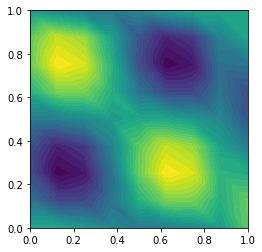

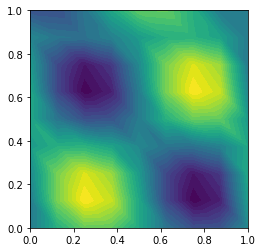

In [19]:
# Compute solution
w = Function(W)
solve(a == L, w)
(sigma1,sigma2,sigma3,u1,u2) = w.split()

# Plot sigma and u
plt.figure()
plot(sigma1)

plt.figure()
plot(sigma2)

plt.show()


In [20]:
LHS = PETScMatrix()
LHS = assemble(a, tensor=LHS)

RHS = PETScVector()
RHS = assemble(L, tensor=RHS)


In [21]:
A_mat = LHS.mat()
b_vec = RHS.vec()

In [22]:
from petsc4py import PETSc
myviewerM = PETSc.Viewer().createASCII(
    "LHS.txt", comm= PETSc.COMM_WORLD)
myviewerV = PETSc.Viewer().createASCII(
    "RHS.txt", comm= PETSc.COMM_WORLD)
A_mat.view(myviewerM)
b_vec.view(myviewerV)

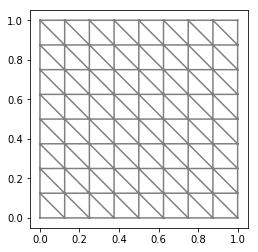

In [23]:
plot(mesh)

In [12]:
myviewerSigma1 = PETSc.Viewer().createASCII(
    "sigma1.txt", comm= PETSc.COMM_WORLD)
s1_vec = sigma1.vector().vec()
s1_vec.view(myviewerSigma1)